In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.cm as cm

In [3]:
class KNNClassifier:
    def __init__(self, k=3, distance_func=None):
        self.k = k
        if distance_func is None:
            self.distance_func = self._euclidean_distance
        else:
            self.distance_func = distance_func

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def _manhattan_distance(self, x1, x2):
        return np.sum(np.abs(x1 - x2))

    def _minkowski_distance(self, x1, x2, p=3):
        return np.sum(np.abs(x1 - x2) ** p) ** (1 / p)

    def predict(self, X):
        predictions = []
        for index, x in enumerate(X):
            distances = [self.distance_func(x, x_train) for x_train in self.X_train]

            # indices of the k nearest neighbors
            k_indices = np.argsort(distances)[:self.k]
            # labels of the k nearest neighbors
            k_neighbor_labels = self.y_train[k_indices]
            # majority vote
            counts = np.bincount(k_neighbor_labels.astype(int))
            predicted_label = np.argmax(counts)
            predictions.append(predicted_label)

        return np.array(predictions)

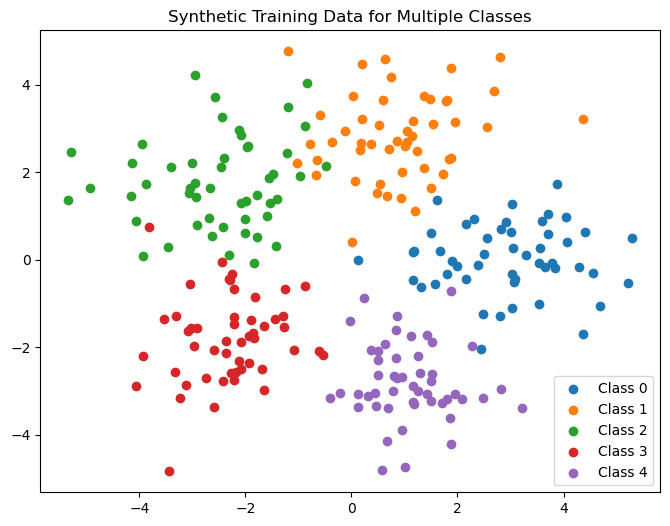

In [4]:
def generate_synthetic_data(m=3, num_points_per_class=100, cluster_std=1.0):
    np.random.seed(40)
    X = []
    y = []
    means = []
    for i in range(m):
        angle = 2 * np.pi * i / m
        radius = 3
        mean = [radius * np.cos(angle), radius * np.sin(angle)]
        means.append(mean)
        cov = [[cluster_std, 0], [0, cluster_std]]
        class_data = np.random.multivariate_normal(mean, cov, num_points_per_class)
        X.append(class_data)
        y += [i] * num_points_per_class

    X = np.vstack(X)
    y = np.array(y)
    return X, y, means

m = 5  # number of classes
num_points_per_class = 50
cluster_std = 1.0

X, y, class_means = generate_synthetic_data(m=m, num_points_per_class=num_points_per_class, cluster_std=cluster_std)

plt.figure(figsize=(8,6))
colors = plt.colormaps['tab10'].colors
for i in range(m):
    plt.scatter(X[y == i, 0], X[y == i, 1], color=colors[i], label=f'Class {i}')
plt.title('Synthetic Training Data for Multiple Classes')
plt.legend()
plt.show()

In [5]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

test_size = 0.2  # 20% for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

print(f"Total samples: {X.shape[0]}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Total samples: 250
Training samples: 200
Testing samples: 50


In [7]:
def plot_decision_boundaries(classifier, X, y, means, title='Decision Boundaries'):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    h = 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = classifier.predict(grid_points)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10,8))
    colors = plt.get_cmap('tab10', np.unique(y).size + 1)

    plt.contourf(xx, yy, Z, alpha=0.5, cmap=colors)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors, edgecolor='k', s=40)

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=f'Class {i}',
                   markerfacecolor=colors(i), markersize=10) for i in range(np.unique(y).size)
    ], loc='upper right')
    plt.show()

In [8]:
distance_func = euclidean_distance

k = 5
knn = KNNClassifier(k=k, distance_func=distance_func)
knn.fit(X_train, y_train)

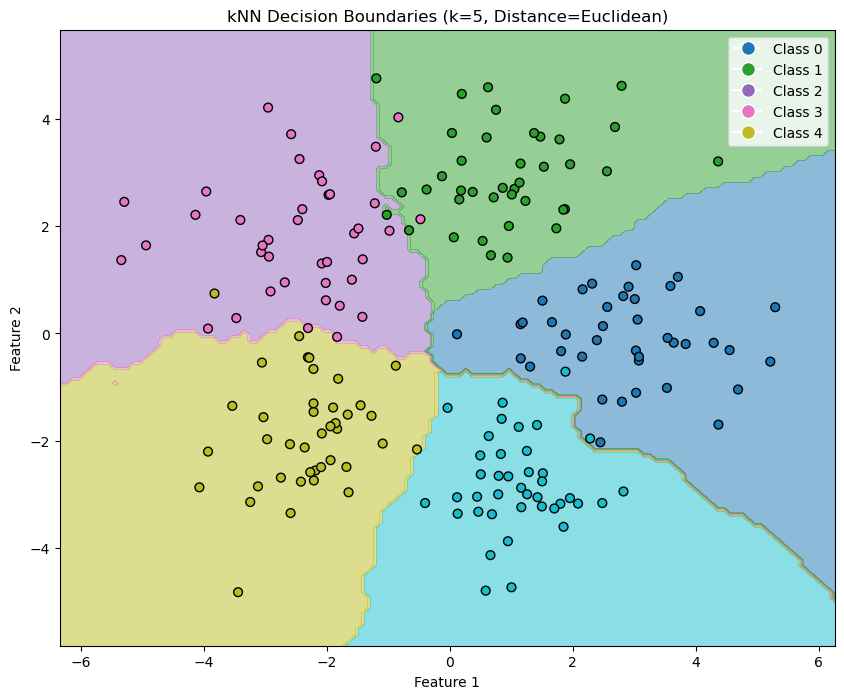

In [9]:
plot_decision_boundaries(
    classifier=knn,
    X=X_train,
    y=y_train,
    means=class_means,
    title=f'kNN Decision Boundaries (k={k}, Distance=Euclidean)'
)

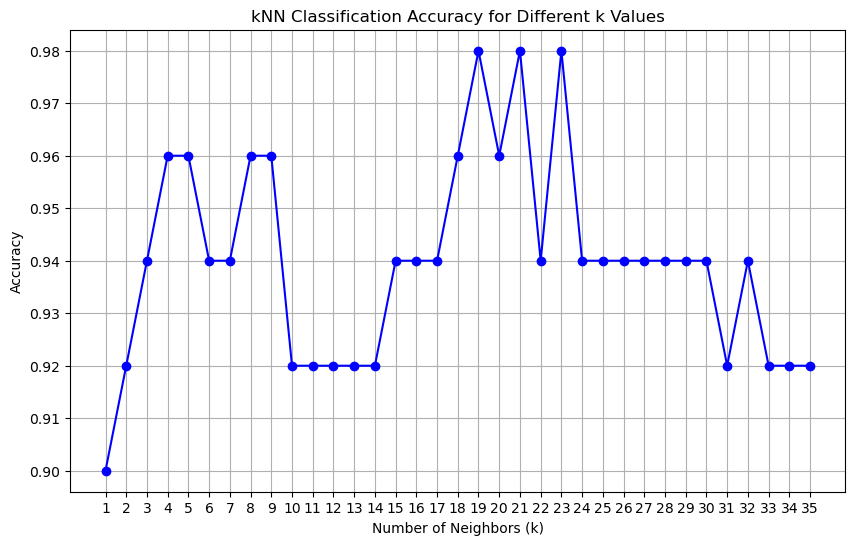

In [10]:
k_values = range(1, 36)

accuracies = []

for k in k_values:
    knn = KNNClassifier(k=k, distance_func=euclidean_distance)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# plotting Accuracy for different values of k
plt.figure(figsize=(10,6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('kNN Classification Accuracy for Different k Values')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()